# COGS 108 - Final Project 

# Overview

It is no news that San Diego is facing a homeless crisis that is affecting the public spaces of the city. Assuming the role of a SD Parks and Rec analyst, I tried to find out if the presence of homeless people is a significant factor in negative Yelp reviews of the parks in San Diego. By applying TF-IDF to two sets of documents which respectively contains good and bad Yelp reviews of parks in San Diego, I was able to find out that the homeless population in parks is indeed a significant reason for bad reviews.

# Name & GitHub

- Name: Xiaochun Lyu
- GitHub Username: XiaochunLyu

# Research Question

Is the presence of homeless people a significant contributing factor to negative Yelp reviews of parks in San Diego?

## Background and Prior Work

Sasn Diego has had the problem of homelessness for a long time, and parks in San Diego are suffering from this problem too. In Sep, 2017, a large crackdown on homeless camps "has forced people without shelter into Balboa Park and other parts of the city"(1). Another report by KPBS in Jan, 2020 detailed the deteriorating at Lamar Park in Spring Valley: "Everyday there's a new tent that comes, everyday new people, new people. Sometimes it's families. Sometimes it's just single people. It's out of control,” Greer, a homeless person, said. She says she has asked the county for help in finding a place to stay. But she hasn't been offered assistance.(2)

Taking the public opinion into account, the situation doesn't look good for everyone, people visiting the parks are being put off by the presence of homeless people, and the homeless themselves also admit that they are in the parks because they have no choice: Chapman, a homeless person at Larmar park told KPBS reporter that "To me it's embarrassing to have to be there to be on top of a park...I can only imagine what parents are feeling. But for us homeless who are elderly, it's the safest place that we feel, it's on a main drag, there's a restroom here."(2)

Efforts have been made to alleviate the situation to some effect: Accoridng to another KPBS report, San Diego County's homeless population dropped 6% from 2019, with a 12% reduction in the number of unsheltered homeless people, according to figures released by the Regional Task Force on the Homeless.(3) However, more remains to be done in order to fully address the homeless crisis in San Diego, especially in parks around the city.

References (include links):
- 1) Homeless move to new parks, streets after camp crackdown, The San Diego Union Tribune, 
https://www.sandiegouniontribune.com/news/hepatitis-crisis/sd-me-homeless-camp-20170928-story.html
- 2) Homeless Encampment In Spring Valley Shows Spread Of San Diego's Homeless Crisis, KPBS, 
https://www.kpbs.org/news/2020/jan/07/growing-homeless-encampment-spring-valley-shows-sp/
- 3) Homelessness Drops In San Diego County, KPBS, 
https://www.kpbs.org/news/2020/apr/29/homelessness-drops-san-diego-county/#:~:text=San%20Diego%20County's%20homeless%20population,3%2C971%20unsheltered%20and%203%2C648%20sheltered.&text=Total%20homeless%20dropped%204%25%20in%20San%20Diego.

# Hypothesis


I think homelessness is likely a significant factor that prompts people to write negative reviews of the parks. My hypothesis comes from skimming the Yelp review dataset, where it seems like a bad review of a park is more likely to mention homeless in the park. Having visited several parks in San Diego my self, I also think that the parks are well maintained and have good facilities. Therefore, I speculate that when people are writing bad reviews, they are more likely to focus on external issues such as homeless people rather than the parks themselves. 

# Dataset(s)

- Dataset Name: SD Parks & Recreation Location Data: Park Locations Data
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/parks_datasd.geojson
- Number of observations: 2769

Description: The Park Locations Data is a geojson dataset that contains the location, size, category and owner information of parks under SD Parks and Rec.

- Dataset Name: San Diego Parks Yelp Data: Reviews
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_reviews.csv
- Number of observations: 2333

Description: The Yelp review data is a csv dataset that contains Yelp reviews of parks under SD Parks and Rec. The dataset includes up to three reviews (review score from 1-5 and review text) for each park and is curated by Professor Ellis with the Yelp API. 

Since there are reviews for other locations in the Yelp review dataset, I will be extracting the names of all parks under SD Parks and Rec from the Park Locations dataset and using this list of names to filter out all review entries in the Yelp review dataset so that I am only working with reviews of parks.

Additionally, I would like to explain the limitations on the Yelp review dataset: Because of the limitation of the Yelp API, each location in the dataset is capped at three reviews only, meaning that for locations with more than three reviews, I could not get every review to form the whole picture. Another limitation of the Yelp API is that the API will decide which review is included in the dataset if there are more than three reviews for a location, and the exact rules of selecting the reviews is unknown. Therefore, The three reviews for a location in the Yelp dataset may not realistically reflect people's thoughts on that location. A third limitation of the Yelp API is that it will truncate review text if it is too long, resulting in loss of information in many entries of the Yelp review dataset. This has the similar implication as the second limitation since it prevents me from accessing and interpreting whole review texts from the dataset.

A final limitation on the datasets is that the park names in the Park Locations dataset sometimes do not match up with the park names in the Yelp review dataset, resulting in me not being able to find all parks and their reviews in the Yelp review dataset. To alleviate the problem, I will be matching locations using both the "name" and the "alias" feature of the Park Location dataset so that I can get as many reviews about parks as I can in the Yelp review dataset.


# Setup

In [145]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [146]:
# Download the NLTK English tokenizer and the stopwords of all languages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/xil536/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/xil536/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [147]:
# import reviews data
YR_filepath='../data/yelp_SD_reviews.csv'
YR_df = pd.read_csv( YR_filepath, header = None )
YR_df = YR_df.rename(columns={0: 'id', 1: 'rating', 2:'review'})
YR_df = YR_df.drop([0])
YR_df = YR_df.reset_index(drop=True)
YR_df.head()

,id,rating,review
0,Balboa Park,5,Balboa Park is a must see when coming to San D...
1,Balboa Park,5,Beautiful grounds even to take a stroll during...
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...
3,Civita Park,5,Was invited to child's B-Day party pre Covid-1...
4,Civita Park,5,"Pretty nice park, beautiful design. Anyone is..."


In [148]:
#import parks location geodata
PL_filepath='../data/parks_datasd.geojson'
PL_df = pd.read_json( PL_filepath)
PL_df.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poly..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poly..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poly..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."


# Data Cleaning

Describe your data cleaning steps here.

In [149]:
# Goal 1: remove all entries on yelp review that is not about a park
# Step 1: remove the useless "type" attrbute of the park location dataset
PL_df = PL_df.drop(['type'], axis=1)
PL_df.head()

,features
0,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
1,"{'type': 'Feature', 'geometry': {'type': 'Poly..."
2,"{'type': 'Feature', 'geometry': {'type': 'Poly..."
3,"{'type': 'Feature', 'geometry': {'type': 'Poly..."
4,"{'type': 'Feature', 'geometry': {'type': 'Mult..."


In [150]:
# helper function to extract park names from the dict object that holds the geodata
def convert_features(feature):
    out_name = feature['properties']['name']
    return out_name
def convert_alias(feature):
    out_alias = feature['properties']['alias']
    return out_alias

In [151]:
# Step 2: apply the function to get the name of all locations that is a "park" under SD Park and Rec and drop the now useless geodata
# Since in the geodata provided parks have "name" and "alias", I include them both to catch as many parks as posssible 
PL_df['name'] = PL_df['features'].apply(convert_features)
PL_df['alias'] =PL_df['features'].apply(convert_alias)
PL_df = PL_df.drop(['features'], axis=1)
PL_df.head()

,name,alias
0,South Carlsbad SB,South Carlsbad State Beach
1,Torrey Pines SB,Torrey Pines State Beach
2,Ruocco Park,Ruocco Park
3,Tuna Harbor Park,Tuna Harbor Park
4,San Diego Bayfront Park,San Diego Bayfront Park


In [152]:
# Step 3: compare the list of parks (PL_df) with the list of yelp reviews to find out all entries about parks in the yelp review dataset 
#Df1.name.isin(Df2.IDs).astype(int)
YR_df['on_name_list'] = YR_df.id.isin(PL_df.name).astype(int)
YR_df['on_alias_list'] = YR_df.id.isin(PL_df.alias).astype(int)
#YR_df
Park_YR_df = YR_df.loc[(YR_df['on_name_list'] == 1 ) | (YR_df['on_alias_list'] == 1)]
Park_YR_df
# Remove the now useless on_name_list and on_alias_list column
Park_YR_df = Park_YR_df.drop(['on_name_list', 'on_alias_list'], axis=1)
Park_YR_df.head()
# Now I have a dataframe that contains 352 entries of reviews on parks under SD Parks and Rec.

,id,rating,review
0,Balboa Park,5,Balboa Park is a must see when coming to San D...
1,Balboa Park,5,Beautiful grounds even to take a stroll during...
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...
6,Waterfront Park,5,"After eating brunch in Little Italy, we decide..."
7,Waterfront Park,5,Definitely worth the price of admission.\n\nIf...


In [153]:
# Step 4: Sanity checks to ensure the dataset is ready to go
# Checking unique values of id:
Park_YR_df['id'].value_counts()
# Notice that there park names that has 6 (!) entries of review, while the yelp review dataset only has a max of 3 reviews
# per location. This is due to more than one location having the same name. For example, there are two Lakeview Parks and 
# three Rolling Hills Park all in different locations.Since my analysis is only concerned with good/bad reviews of parks in
# general and the number of times "homeless" is mentioned in the reviews, the bias caused by duplicate park names should not
# be too concerning.

Rolling Hills Park              6
Lakeview Park                   6
Mesa Verde Park                 6
Mission Trails Regional Park    6
Memorial Park                   6
                               ..
Villa Monserate Park            2
Ashley Falls Park               2
Vista Pacifica Park             1
Teralta Park                    1
Sunnyslope Park                 1
Name: id, Length: 112, dtype: int64

In [154]:
# Goal 2: Ensuring cleanliness of data
# Step 1: Checking NaN values:
print('number of NaNs in id: ')
print(Park_YR_df['id'].isna().sum())
print('number of NaNs in rating: ')
print(Park_YR_df['rating'].isna().sum())
print('number of NaNs in review: ')
print(Park_YR_df['review'].isna().sum())

number of NaNs in id: 
0
number of NaNs in rating: 
0
number of NaNs in review: 
0


There are no NaN values anywhere! This is a good sign that my data is clean. I did not check whether there are other illegal entries because they should have been already taken care of: My process of only finding reviews about parks under SD Parks and Rec by matching names should eliminate all illegal entries in the "id" column; The "rating" column should not have any illegal values to begin with because the data is obtained by using the Yelp API, and I can assume with confidence that Yelp will not generate a rating with illegal values in the first place; Since the "review" column is also obtained via Yelp API, I can still only assume (albeit with less confidence) that there are no gibberish in the "review" column. Since I am doing TF-IDF on the reviews, even if there are a few gibberish reviews, the resulting bias would not be too big since: 1) a few meaningless words will not rank too high on the TF-IDF scale. 2) I am looking at words individually so the context is already removed in the process.

In [155]:
# Step 2: convert the rating from strings into int values
def convert_rating(rating):
    if rating == '5':
        out = 5
    elif rating == '4':
        out = 4
    elif rating == '3':
        out = 3
    elif rating == '2':
        out = 2
    else:
        out = 1
    return out

In [156]:
Park_YR_df['numrating'] = Park_YR_df['rating'].apply(convert_rating)
Park_YR_df

,id,rating,review,numrating
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,5
1,Balboa Park,5,Beautiful grounds even to take a stroll during...,5
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...,5
6,Waterfront Park,5,"After eating brunch in Little Italy, we decide...",5
7,Waterfront Park,5,Definitely worth the price of admission.\n\nIf...,5
...,...,...,...,...
2207,Ashley Falls Park,5,New playground for my 4 yo and 10month old. Bu...,5
2208,Ashley Falls Park,4,came here for a kids birthday party...not my f...,4
2239,Cuvier Park,5,Cuvier Park also known as The Wedding Bowl. Th...,5
2240,Cuvier Park,5,I cannot think of an ugly beach in La Jolla or...,5


# Data Analysis & Results

Here I seperate the Yelp review dataset on parks into two groups. Because I want to use TF-IDF to see if homeless people is a significant factor in negative reviews, I seperate the dataset into good reviews (with rating 3-5) and bad reviews (with rating 1-2).

In [157]:
# Seperate Yelp review data into 2 sets of documents for TF-IDF
good_review_df = Park_YR_df.loc[(Park_YR_df['numrating'] >= 3 )]
bad_review_df = Park_YR_df.loc[(Park_YR_df['numrating'] < 3)]

In [158]:
good_review_df.head()

,id,rating,review,numrating
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,5
1,Balboa Park,5,Beautiful grounds even to take a stroll during...,5
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...,5
6,Waterfront Park,5,"After eating brunch in Little Italy, we decide...",5
7,Waterfront Park,5,Definitely worth the price of admission.\n\nIf...,5


In [159]:
bad_review_df.head()

,id,rating,review,numrating
287,Edward Tyler Cramer Park,1,There is NO PARKING. This is a taxpayer mainta...,1
318,Western Hills Park,2,I almost got a ticket there for having my dog ...,2
352,Kearny Mesa Park,1,This park is a good alternative to Lindbergh P...,1
377,Parkside Park,1,Wow fuck the city and its park and rec departm...,1
428,Lamar Park,1,This park had huge potential until the very la...,1


Here I am doing a bit of EDA to see the frequency of the word "homeless" and other words to get an understanding of the frequency distribution of the words.

In [160]:
## import word tokenizer
from nltk.tokenize import word_tokenize

In [161]:
good_review_df['review_token'] = good_review_df['review'].apply(word_tokenize) 
bad_review_df['review_token'] = bad_review_df['review'].apply(word_tokenize) 


In [162]:
good_review_df.head()

,id,rating,review,numrating,review_token
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,5,"[Balboa, Park, is, a, must, see, when, coming,..."
1,Balboa Park,5,Beautiful grounds even to take a stroll during...,5,"[Beautiful, grounds, even, to, take, a, stroll..."
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...,5,"[Beautiful, sightseeing, in, San, Diego, ., Lo..."
6,Waterfront Park,5,"After eating brunch in Little Italy, we decide...",5,"[After, eating, brunch, in, Little, Italy, ,, ..."
7,Waterfront Park,5,Definitely worth the price of admission.\n\nIf...,5,"[Definitely, worth, the, price, of, admission,..."


In [163]:
bad_review_df.head()

,id,rating,review,numrating,review_token
287,Edward Tyler Cramer Park,1,There is NO PARKING. This is a taxpayer mainta...,1,"[There, is, NO, PARKING, ., This, is, a, taxpa..."
318,Western Hills Park,2,I almost got a ticket there for having my dog ...,2,"[I, almost, got, a, ticket, there, for, having..."
352,Kearny Mesa Park,1,This park is a good alternative to Lindbergh P...,1,"[This, park, is, a, good, alternative, to, Lin..."
377,Parkside Park,1,Wow fuck the city and its park and rec departm...,1,"[Wow, fuck, the, city, and, its, park, and, re..."
428,Lamar Park,1,This park had huge potential until the very la...,1,"[This, park, had, huge, potential, until, the,..."


In [164]:
# Import stop words and clean stopwords from tokenized data
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
good_review_df['review_stop'] = good_review_df['review_token'].apply(lambda x: [item for item in x if item not in stop_words])
bad_review_df['review_stop'] = bad_review_df['review_token'].apply(lambda x: [item for item in x if item not in stop_words])

In [165]:
good_review_df.head()

,id,rating,review,numrating,review_token,review_stop
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,5,"[Balboa, Park, is, a, must, see, when, coming,...","[Balboa, Park, must, see, coming, San, Diego, ..."
1,Balboa Park,5,Beautiful grounds even to take a stroll during...,5,"[Beautiful, grounds, even, to, take, a, stroll...","[Beautiful, grounds, even, take, stroll, Covid..."
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...,5,"[Beautiful, sightseeing, in, San, Diego, ., Lo...","[Beautiful, sightseeing, San, Diego, ., Lots, ..."
6,Waterfront Park,5,"After eating brunch in Little Italy, we decide...",5,"[After, eating, brunch, in, Little, Italy, ,, ...","[After, eating, brunch, Little, Italy, ,, deci..."
7,Waterfront Park,5,Definitely worth the price of admission.\n\nIf...,5,"[Definitely, worth, the, price, of, admission,...","[Definitely, worth, price, admission, ., If, l..."


In [166]:
bad_review_df.head()

,id,rating,review,numrating,review_token,review_stop
287,Edward Tyler Cramer Park,1,There is NO PARKING. This is a taxpayer mainta...,1,"[There, is, NO, PARKING, ., This, is, a, taxpa...","[There, NO, PARKING, ., This, taxpayer, mainta..."
318,Western Hills Park,2,I almost got a ticket there for having my dog ...,2,"[I, almost, got, a, ticket, there, for, having...","[I, almost, got, ticket, dog, leash, ., It, 's..."
352,Kearny Mesa Park,1,This park is a good alternative to Lindbergh P...,1,"[This, park, is, a, good, alternative, to, Lin...","[This, park, good, alternative, Lindbergh, Par..."
377,Parkside Park,1,Wow fuck the city and its park and rec departm...,1,"[Wow, fuck, the, city, and, its, park, and, re...","[Wow, fuck, city, park, rec, department, ., Yo..."
428,Lamar Park,1,This park had huge potential until the very la...,1,"[This, park, had, huge, potential, until, the,...","[This, park, huge, potential, large, homeless,..."


In [167]:
# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()

good_review_df['review_stem'] = good_review_df['review_stop'].apply(lambda x: [ps.stem(y) for y in x])
bad_review_df['review_stem'] = bad_review_df['review_stop'].apply(lambda x: [ps.stem(y) for y in x])

In [168]:
good_review_df.head()

,id,rating,review,numrating,review_token,review_stop,review_stem
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,5,"[Balboa, Park, is, a, must, see, when, coming,...","[Balboa, Park, must, see, coming, San, Diego, ...","[balboa, park, must, see, come, san, diego, .,..."
1,Balboa Park,5,Beautiful grounds even to take a stroll during...,5,"[Beautiful, grounds, even, to, take, a, stroll...","[Beautiful, grounds, even, take, stroll, Covid...","[beauti, ground, even, take, stroll, covid, 's..."
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...,5,"[Beautiful, sightseeing, in, San, Diego, ., Lo...","[Beautiful, sightseeing, San, Diego, ., Lots, ...","[beauti, sightse, san, diego, ., lot, walkway,..."
6,Waterfront Park,5,"After eating brunch in Little Italy, we decide...",5,"[After, eating, brunch, in, Little, Italy, ,, ...","[After, eating, brunch, Little, Italy, ,, deci...","[after, eat, brunch, littl, itali, ,, decid, w..."
7,Waterfront Park,5,Definitely worth the price of admission.\n\nIf...,5,"[Definitely, worth, the, price, of, admission,...","[Definitely, worth, price, admission, ., If, l...","[definit, worth, price, admiss, ., If, love, s..."


In [169]:
bad_review_df.head()

,id,rating,review,numrating,review_token,review_stop,review_stem
287,Edward Tyler Cramer Park,1,There is NO PARKING. This is a taxpayer mainta...,1,"[There, is, NO, PARKING, ., This, is, a, taxpa...","[There, NO, PARKING, ., This, taxpayer, mainta...","[there, NO, park, ., thi, taxpay, maintain, pa..."
318,Western Hills Park,2,I almost got a ticket there for having my dog ...,2,"[I, almost, got, a, ticket, there, for, having...","[I, almost, got, ticket, dog, leash, ., It, 's...","[I, almost, got, ticket, dog, leash, ., It, 's..."
352,Kearny Mesa Park,1,This park is a good alternative to Lindbergh P...,1,"[This, park, is, a, good, alternative, to, Lin...","[This, park, good, alternative, Lindbergh, Par...","[thi, park, good, altern, lindbergh, park, wan..."
377,Parkside Park,1,Wow fuck the city and its park and rec departm...,1,"[Wow, fuck, the, city, and, its, park, and, re...","[Wow, fuck, city, park, rec, department, ., Yo...","[wow, fuck, citi, park, rec, depart, ., you, '..."
428,Lamar Park,1,This park had huge potential until the very la...,1,"[This, park, had, huge, potential, until, the,...","[This, park, huge, potential, large, homeless,...","[thi, park, huge, potenti, larg, homeless, enc..."


Quick analysis: word frequency
Here I can visulize word frequencies by using a FreqDict

In [170]:
good_review_words = good_review_df['review_stem'].apply(pd.Series).stack()
bad_review_words = bad_review_df['review_stem'].apply(pd.Series).stack()
# import and using FreqDist
from nltk.probability import FreqDist
import string

# calculation word frequency
fdist_good = FreqDist(good_review_words)
fdist_bad = FreqDist(bad_review_words)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_good[punc]
    del fdist_bad[punc]

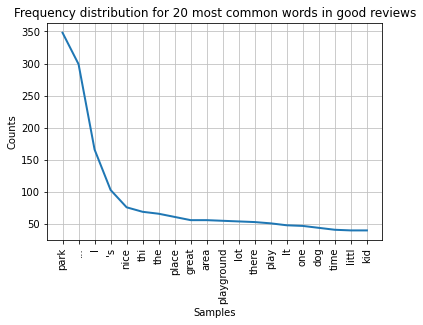

In [171]:
# Visualization:
# Frequency Distribution Plot - top 20
# for words in "good" reviews (rated 3-5)
fdist_good.plot(20, title='Frequency distribution for 20 most common words in good reviews', cumulative=False)

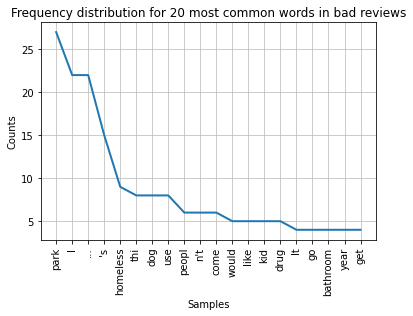

In [172]:
# Visualization:
# Frequency Distribution Plot - top 20
# for words in "bad" reviews (rated 1-2)
fdist_bad.plot(20, title='Frequency distribution for 20 most common words in bad reviews', cumulative=False)

The result above already seems to indicate something, as "homeless" ranks pretty high on the frequency distribution of words in negative reviews. Notice that the words that ranked higher than homeless: "park", "I", "..." and "'s" are all relatively common (meaningless) for the analysis, which further reinforced my guess that homeless people in parks is an important factor in negative reviews. Still, further analysis with TF-IDF needs to be conducted in order to reach a solid conclusion.


In [173]:
# get a list of words from good reviews and bad reviews
good_list = list(good_review_df['review'].values)
bad_list = list(bad_review_df['review'].values)

In [174]:
# Prepare for TF-IDF by constructing the corpus
import string 

# lowercase text
good = list(map(str.lower, good_list))
bad = list(map(str.lower, bad_list))

# remove punctuation
for c in string.punctuation:
    good = str(good).replace(c, "")
    bad = str(bad).replace(c, "")

# get list of two documents together
corpus = [str(good), str(bad)]

In [175]:
# Import and create vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# create vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words=stop_words)

In [176]:
# calculate TF-IDF
reviews_tfidf = pd.DataFrame(tfidf.fit_transform(corpus).toarray())
reviews_tfidf.columns = tfidf.get_feature_names()
reviews_tfidf = reviews_tfidf.rename(index={0:'good', 1:'bad'})

In [177]:
# Sorting the result and find out how unique the word is to each document based on TF-IDF values
reviews_tfidf.sort_values(by='bad', axis=1, ascending=False)

,park,homeless,dog,people,go,like,used,kids,come,n,...,guests,guess,guards,growing,groups,grounds,grossmont,gripe,grey,youre
good,0.071569,0.018235,0.049363,0.044996,0.042480,0.044996,0.030066,0.049945,0.043558,0.000000,...,0.025628,0.015136,0.015136,0.015136,0.015136,0.031765,0.015136,0.015136,0.015136,0.031765
bad,0.178575,0.135331,0.130346,0.118169,0.110451,0.110451,0.110451,0.101006,0.101006,0.100725,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [178]:
reviews_tfidf.sort_values(by='good', axis=1, ascending=False)

,great,park,area,little,san,diego,well,beach,beautiful,love,...,fine,permanently,caters,load,concern,listen,lindbergh,lil,bombarded,periodically
good,0.076065,0.071569,0.071346,0.070972,0.068061,0.066618,0.066105,0.066105,0.065023,0.06324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000
bad,0.000000,0.178575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.05949,0.05949,0.05949,0.05949,0.05949,0.05949,0.05949,0.100725,0.05949,0.05949


In bad reviews, "homeless" has a TF-IDF score of 0.135, while in good reviews "homeless" only have a TF-IDF score of 0.018. The large difference in TF-IDF scores suggests that the word "homeless" is significantly more important to the set of document that contains bad reviews than to the set that contains good reviews.

In [179]:
# Visualizing data by plotting bar graph
# Find the top 10 words that has highest TF-IDF values in each set of documents
bad_reviews_tfidf = reviews_tfidf.sort_values(by='bad', axis=1, ascending=False)
bad_reviews_tfidf = bad_reviews_tfidf.iloc[1:2, 0:10]
good_reviews_tfidf = reviews_tfidf.sort_values(by='good', axis=1, ascending=False)
good_reviews_tfidf = good_reviews_tfidf.iloc[0:1, 0:10]

# Prepare dataframe for visualization by transposing the dataframe
bad_tfidf_viz = bad_reviews_tfidf.T
bad_tfidf_viz = bad_tfidf_viz.rename(columns={"bad": "TF-IDF score"})
good_tfidf_viz = good_reviews_tfidf.T
good_tfidf_viz = good_tfidf_viz.rename(columns={"good": "TF-IDF score"})

Text(0, 0.5, 'TF-IDF score')

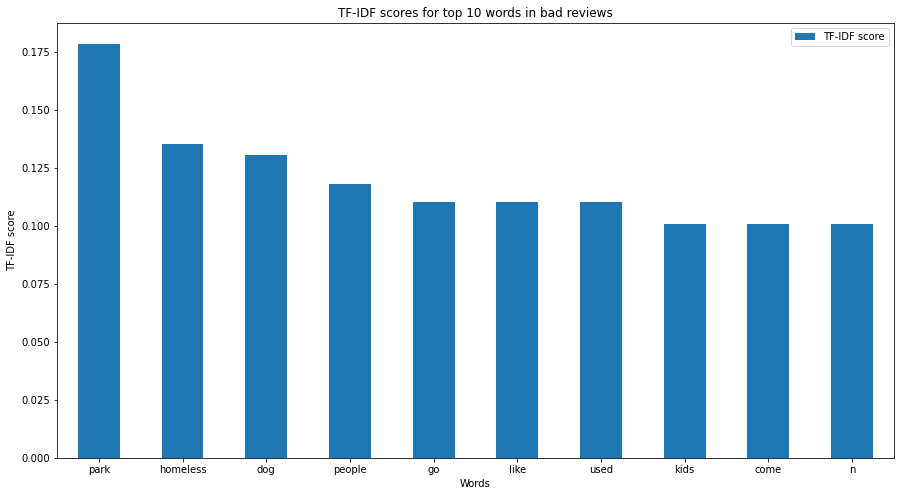

In [180]:
# Plot the bar graph
bad_viz_bar = bad_tfidf_viz.plot.bar(x=None, y=None, rot=0, title = 'TF-IDF scores for top 10 words in bad reviews', figsize=(15,8))
bad_viz_bar.set_xlabel("Words")
bad_viz_bar.set_ylabel("TF-IDF score")


As the above bar graph shows, the word "homeless" is extremely revelant to the set of document that contains bad reviews. In fact, it sits at second place in TF-IDF scores, only behind "park" which is the subject matter of these reviews.

Text(0, 0.5, 'TF-IDF score')

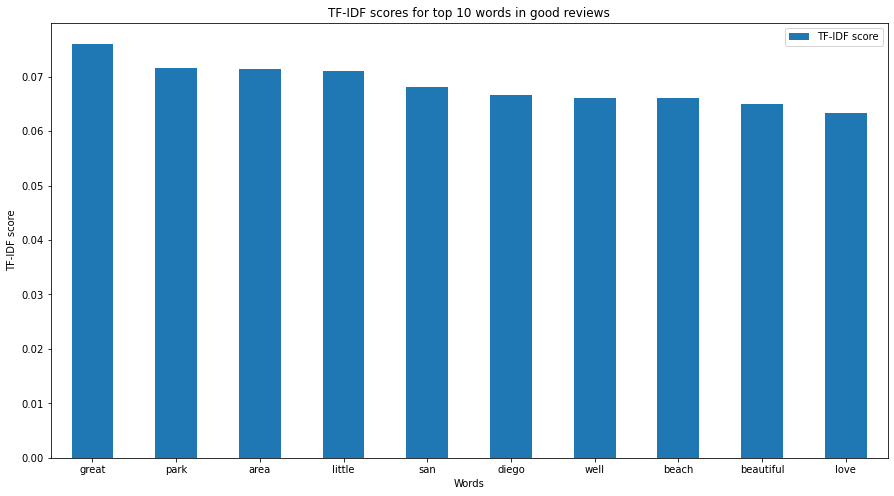

In [181]:
# Plot the bar graph
good_viz_bar = good_tfidf_viz.plot.bar(x=None, y=None, rot=0, title = 'TF-IDF scores for top 10 words in good reviews', figsize=(15,8))
good_viz_bar.set_xlabel("Words")
good_viz_bar.set_ylabel("TF-IDF score")

As the above bar graph shows, the words that are most revelant in positive reviews are all positive words that one would expect, and "homeless" is not one of them.

Text(0, 0.5, 'TF-IDF score')

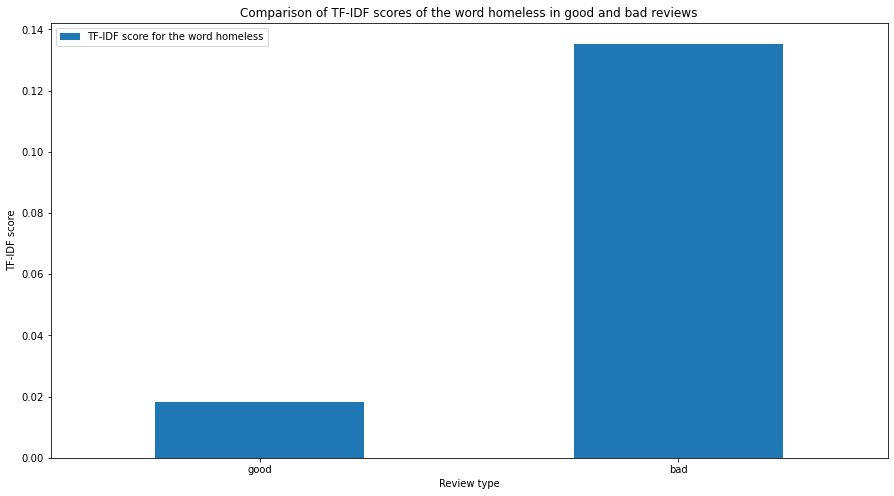

In [182]:
tfidf_comparison_df = reviews_tfidf.sort_values(by='bad', axis=1, ascending=False)
tfidf_comparison_df = tfidf_comparison_df.iloc[0:2, 1:2]
tfidf_comparison_df = tfidf_comparison_df.rename(columns={"homeless": "TF-IDF score for the word homeless"})
comparison_viz_bar = tfidf_comparison_df.plot.bar(x=None, y=None, rot=0, title = 'Comparison of TF-IDF scores of the word homeless in good and bad reviews', figsize=(15,8))
comparison_viz_bar.set_xlabel("Review type")
comparison_viz_bar.set_ylabel("TF-IDF score")

The above bar graph shows the huge difference in TF-IDF scores for the word "homeless" in good and bad Yelp reviews. The nearly tenfold difference shows that the word "homeless" is much more revelant in bad reviews than in good reviews, thus being a big factor in bad reviews of the parks in San Diego.

# Ethics & Privacy

Ethics:
Since I am basing my project on the Yelp review dataset that comes with a lot of limitations, I would like to detail my concern on ethics of this project. I do have the permission to use the data, as the Park Location data is public accessible and the Yelp review data is curated by Professor Ellis. However, the numerous limitations on my project and the ethics concerns they pose is worth discussing here. Since the Yelp review datset cannot realistically reflect what people think about the parks due to the limitation of three comments only and review truncating, my data is likely to contain bias that affects my text analysis. Additionally, because I am employing word frequency analysis in my EDA and IF-IDF in my formal analysis, I am removing the context of individual words in the comments, thus introducing additional bias into my analysis. This is expecially true for the word "homeless". Since I am only comparing the TF-IDF scores of this word in good comments and bad comments, I can only know how important this word is to the set of good reviews and bad reviews, but can never fully grasp what people want to say when they mentioned "homeless" in the reviews. In short, given the limitations in both the dataset and my methods, my research is prone to paint a wrong picture about homeless people and park reviews. Finally, my research is only directed at Yelp reviews of parks in SD, therefore the results is can neither represent the parks and homeless people elsewhere, nor represent the thoughts of people who wrote reviews on a platform other than Yelp, as well as the thoughts of people who didn't write any reviews at all. I would like to make it clear that my research is not to be misused in anyway that paints a skewed picture of the homeless poputation in San Diego and park reviews/reviewers.

Privacy:
The two datasets I used in my project contain little privacy concerns due to the following reasons: 
1) The Park Location dataset simply does not contain any personal information since it only contains the locations and ther information of parks.
2) The Yelp review dataset is retrieved using the Yelp API, and the API already stripped all information about the Yelp users that posted these reviews.
3) The only place where personal information can be present is in the review themselves, as there is a non-zero chance that a reviewer accidentally revealed personal information in his/her reviews. However, such case is not only rare, but has less impact because when a person writes a review and posts it online, the person is already consenting to release the review to a public domain for everyone to view.
Although the data I used contains little privacy concern, I would still insist on keeping the data and my project undisclosed because there is a chance that the review section contains personally identifiable information, and it is out of my ability to identify and delete these information since I will have to manually read through all review entries.

# Conclusion & Discussion

Based on the analysis which revealed a huge difference in TF-IDF scores for the word "homeless" in good reviews and bad reviews of parks in San Diego, I conclude my hypothesis that the presence of homeless population is a significant factor that contributes to negative Yelp reviews of parks under SD Parks and Rec is right. And this conclusion may provide more incentive for the city to provide shelter/housing to its homeless population as it creates a win-win scenario: the homeless people are provided with housing, and people will have more positive opinions on parks in San Diego since the homeless population, a significant factor contributing to nagative reviews, is no longer in the parks. 

I would like to reiterate that my project contains numerous limitations introduced by the dataset and my methodology, and in no way representative of the whole situation regarding the homeless population and parks in San Diego. Apart from the data-introduced limitations which I cannot work around, my method of using TF-IDF only also introduced limitations to my analysis since TF-IDF only looks at the relevancy of individual words and removes all context. 